# Notebook for the Inventory Management Problem
## Attack computation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from inventory import Inventory
from attacker import *
from utils import *

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "legend.fontsize": 14})
plt.rcParams['pgf.preamble'] = r"\\usepackage{units} \\usepackage{amsmath} \\usepackage{metalogo} \\usepackage{unicode-math} \\setmainfont{DejaVu Serif} \\setmathfont{xits-math.otf}"
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Setup problem

In [3]:
inventory_size = 35
gamma = 0.95
env = Inventory(inventory_size)
dim_state, dim_action = env.P.shape[0], env.P.shape[1]
V, pi = value_iteration(env, gamma)
unpoisoned_stationary_distribution = compute_stationary_distribution(env.P, pi).tolist()

## Compute constrained attack

In [13]:
epsilons_det = np.arange(7)
atk_value_det = []
inf_value_det = []
alpha = [1 / env.P.shape[0]] * env.P.shape[0]
# alpha[-1] = 1
for epsilon in epsilons_det:
    v, phi, mud = compute_deterministic_attack(gamma, 0., env.P, -env.R, pi, lambda x,y: np.abs(x-y) <= epsilon, alpha)
    mu = compute_stationary_distribution(env.P, phi)
    I, _ = compute_I(mu, env.P, pi, phi)
    atk_value_det.append(-np.mean(v))  # v[-1])
    inf_value_det.append(I)

## Compute stealthy deterministic attack

In [14]:
betas = np.concatenate([np.linspace(0, 8, 10), np.geomspace(8, 15, 10)])
atk_value_det2 = []
inf_value_det2 = []
alpha = [1 / env.P.shape[0]] * env.P.shape[0]
# alpha[-1] = 1
for beta in betas:
    v, phi, mud = compute_deterministic_attack(gamma, beta, env.P, -env.R, pi, lambda x,y: True, alpha)
    mu = compute_stationary_distribution(env.P, phi)
    I, _ = compute_I(mu, env.P, pi, phi)
    atk_value_det2.append(-np.mean(v)) # v[-1])
    inf_value_det2.append(I)

## Compute stealthy random attack

In [15]:
alpha = [1 / env.P.shape[0]] * env.P.shape[0]
#alpha[-1] = 1
atk_value_rnd = []
inf_value_rnd = []
epsilons_rnd = np.linspace(1e-4, 0.5, 15)
for epsilon in epsilons_rnd:
    v, phi, mud = compute_randomized_attack(gamma, epsilon, env.P, -env.R, pi, alpha)
    mu = compute_stationary_distribution(env.P, phi)
    I, _ = compute_I(mu, env.P, pi, phi)
    atk_value_rnd.append(-v)
    inf_value_rnd.append(I)

## Plot results

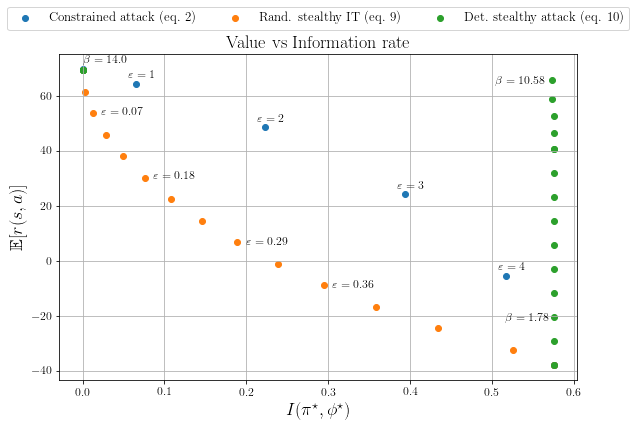

In [17]:
fig, ax = plt.subplots(1,1, figsize=(9, 6))
ax.scatter(inf_value_det, atk_value_det, label='Constrained attack (eq. 2)')
ax.scatter(inf_value_rnd, atk_value_rnd, label='Rand. stealthy IT (eq. 9) ')
ax.scatter(inf_value_det2, atk_value_det2, label='Det. stealthy attack (eq. 10)')

for i, eps in enumerate(epsilons_det):
    if i == 5:
        pass
        #word = r'$\varepsilon\geq{}$'.format(eps)
        #plt.text(inf_value_det[i]-0.05, atk_value_det[i]-3, word, fontsize=12)
    elif i <5 and i>0:
        word = r'$\varepsilon={}$'.format(eps)
        plt.text(inf_value_det[i]-0.01, atk_value_det[i]+2, word, fontsize=12)
        
for i, eps in enumerate(epsilons_rnd):
    if i == 2 or i == 5 or  i == 8 or i == 10:
        word = r'$\varepsilon ={}$'.format(np.round(eps, 2))
        plt.text(inf_value_rnd[i]+0.01, atk_value_rnd[i]-0.7, word, fontsize=12)

for i, beta in enumerate(betas):
    if i == 2:
        word = r'$\beta ={}$'.format(np.round(beta, 2))
        plt.text(inf_value_det2[i]-0.06, atk_value_det2[i]-1.5, word, fontsize=12)
    if i == 14:
        word = r'$\beta ={}$'.format(np.round(beta, 2))
        plt.text(inf_value_det2[i]-0.07, atk_value_det2[i]-1.5, word, fontsize=12)
    if i == 18:
        word = r'$\beta ={}$'.format(np.round(beta, 1))
        plt.text(inf_value_det2[i], atk_value_det2[i]+2.5, word, fontsize=12)
#ax.invert_xaxis()
ax.set_ylabel(r'$\mathbb{E}[r(s,a)]$')
ax.set_xlabel(r'$I(\pi^\star,\phi^\star)$')
ax.set_title('Value vs Information rate')
ax.grid()

fig.subplots_adjust(left=0.1, right=0.9)  # create some space below the plots by increasing the bottom-value
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.165), ncol=3, fontsize=13)
plt.plot()
plt.savefig("inventory_attack_evaluation_final.pdf",bbox_inches="tight")

## Save results

In [18]:
import pickle

data = {'det': [inf_value_det, atk_value_det, epsilons_det],
     'rnd': [inf_value_rnd, atk_value_rnd, epsilons_rnd],
     'det2': [inf_value_det2, atk_value_det2, betas]}

with open('data_attack.pkl', 'wb') as handle:
    pickle.dump(data, handle)
